<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
import requests,json


In [0]:

#!mkdir -p covid_data/tpm_atlantic && mkdir -p covid_data/jhu
#!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/03-14-2020.csv --quiet --output-document ./covid_data/jhu/20200314.csv


In [0]:
covidtrackingurl = "https://covidtracking.com/api/states/daily"
response = requests.get(covidtrackingurl)
dfData = pd.DataFrame(response.json())
dfData.fillna(0, inplace=True)
dfData.negative = dfData.negative.astype('int64')
dfData.positive = dfData.positive.astype('int64')
dfData.pending = dfData.pending.astype('int64')
dfData.total = dfData.total.astype('int64')
dfData.death = dfData.death.astype('int64')


In [3]:
dfData.head()

,date,state,positive,negative,pending,death,total
0,20200315,AK,1,143,0,0,144
1,20200315,AL,12,28,46,0,86
2,20200315,AR,16,103,30,0,149
3,20200315,AZ,12,121,50,0,183
4,20200315,CA,293,916,0,5,1209


In [0]:
#Setthe current date for new cells
current_date = 20200314


In [0]:
#dfData = pd.read_csv("/content/covid_data/tpm_atlantic/cvstate20200314.tsv",
#                     sep='\t', thousands=',')
#dfData.loc[(dfData.Date == 20200309) & (dfData.State=='WA'),['Negative']]= 1100
#dfData.fillna(0, inplace=True)
#dfData.Negative = dfData.Negative.astype('int64')
#dfData.Positive = dfData.Positive.astype('int64')
#dfData.Pending = dfData.Pending.astype('int64')
#dfData.Total = dfData.Total.astype('int64')
#dfData.Death = dfData.Death.astype('int64')

In [0]:
#data correction on 3/13. This may go away
dfData.loc[(dfData.state=='CA')& (dfData.date==20200313), ['positive']]=247

In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/hmacBlues/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [9]:
dfWHO

,confirmed,who_deaths
date,,
20200304,108,6
20200305,129,9
20200306,148,10
20200307,213,11
20200308,213,11
20200309,213,11
20200310,472,19
20200311,696,25
20200312,987,29


In [10]:
res = dfData.loc[dfData.date==current_date, ['positive', 'negative', 'pending', 'total']].sum()
print(res)
print(f"Current Infection Rate {res.positive/res.total*100:2f}%")

positive     2450
negative    17107
pending      1236
total       20795
dtype: int64
Current Infection Rate 11.781678%


In [11]:
dfData.loc[dfData.date==current_date,['state', 'positive']].sort_values(by='positive', ascending=False).head(10)

,state,positive
98,WA,568
85,NY,524
55,CA,252
70,MA,138
56,CO,101
60,FL,77
69,LA,69
61,GA,66
94,TX,51
82,NJ,50


In [0]:
#Compare growth from 20200311 and 202020313
dtstart = 20200311
dtend = 20200313
dfCA = dfData[dfData.state=='CA']

In [13]:
arCols = ['positive', 'negative', 'death']
arTotCols= ['positive', 'negative']

dfUSA0311 = dfData.loc[dfData.date == dtstart, arCols].sum()
print(dfUSA0311)
print(dfUSA0311.loc[arTotCols].sum())
dfUSA0313 = dfData.loc[dfData.date == dtend, arCols].sum()
print(dfUSA0313)
print(dfUSA0313.loc[arTotCols].sum())


positive    1053
negative    5978
death         27
dtype: int64
7031
positive     1967
negative    13513
death          39
dtype: int64
15480


In [0]:
dfUSA = dfData.groupby(['date'])
dfCA = dfData[dfData.state=='CA'].groupby(['date'])

dfUSAPos = dfUSA.positive.sum().reset_index().copy()
dfCAPos = dfCA.positive.sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 
dfUSAPos['PCT']= dfUSAPos.positive/dfUSAPos.max().positive
dfCAPos['PCT']=dfCAPos.positive/dfCAPos.max().positive

In [15]:
dfUSAPos

,date,positive,PCT
0,20200304,118,0.037189
1,20200305,176,0.055468
2,20200306,223,0.070280
3,20200307,341,0.107469
4,20200308,417,0.131421
5,20200309,584,0.184053
6,20200310,778,0.245194
7,20200311,1053,0.331863
8,20200312,1315,0.414434
9,20200313,1967,0.619918


In [16]:
dfCAPos

,date,positive,PCT
0,20200304,53,0.180887
1,20200305,53,0.180887
2,20200306,60,0.204778
3,20200307,69,0.235495
4,20200308,88,0.300341
5,20200309,114,0.389078
6,20200310,133,0.453925
7,20200311,157,0.535836
8,20200312,202,0.689420
9,20200313,247,0.843003


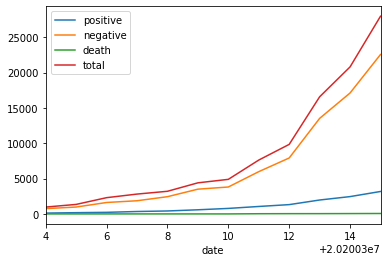

In [17]:
dfUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

In [18]:
dfUSA.sum()

,positive,negative,pending,death,total
date,,,,,
20200304,118,748,103,0,969
20200305,176,971,197,0,1344
20200306,223,1617,458,0,2298
20200307,341,1863,602,0,2806
20200308,417,2437,347,0,3201
20200309,584,3500,313,0,4397
20200310,778,3807,469,0,4889
20200311,1053,5978,563,27,7617
20200312,1315,7913,673,36,9836


In [0]:
dfResults = dfUSA.sum().join(dfWHO, how='left', rsuffix='_who' )

In [20]:
dfResults.tail()

,positive,negative,pending,death,total,confirmed,who_deaths
date,,,,,,,
20200311,1053,5978,563,27,7617,696.0,25.0
20200312,1315,7913,673,36,9836,987.0,29.0
20200313,1967,13513,1130,39,16565,1264.0,36.0
20200314,2450,17107,1236,49,20795,1678.0,41.0
20200315,3173,22548,2242,60,27963,NaN,NaN


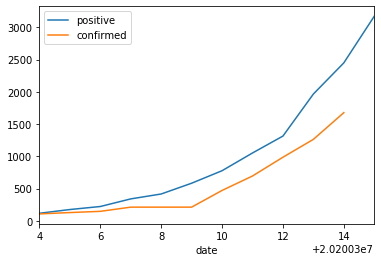

In [21]:
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

In [22]:
dfData[dfData.state=='CA'].sort_values(by='date')

,date,state,positive,negative,pending,death,total
520,20200304,CA,53,462,0,0,515
496,20200305,CA,53,462,0,0,515
460,20200306,CA,60,462,0,0,522
410,20200307,CA,69,462,0,0,531
359,20200308,CA,88,462,0,0,550
310,20200309,CA,114,690,0,0,804
259,20200310,CA,133,690,0,0,823
208,20200311,CA,157,916,0,0,1073
157,20200312,CA,202,916,0,4,1118
106,20200313,CA,247,916,0,4,1118


In [23]:
dfResults

,positive,negative,pending,death,total,confirmed,who_deaths
date,,,,,,,
20200304,118,748,103,0,969,108.0,6.0
20200305,176,971,197,0,1344,129.0,9.0
20200306,223,1617,458,0,2298,148.0,10.0
20200307,341,1863,602,0,2806,213.0,11.0
20200308,417,2437,347,0,3201,213.0,11.0
20200309,584,3500,313,0,4397,213.0,11.0
20200310,778,3807,469,0,4889,472.0,19.0
20200311,1053,5978,563,27,7617,696.0,25.0
20200312,1315,7913,673,36,9836,987.0,29.0


In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/03-14-2020.csv"
dfJHUData = pd.read_csv(jhurl, header=0,
                        names=['state', 'country', 'last_update',
                               'confirmed', 'dead', 'recovered', 'lat','lon'])

In [25]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    2726
dead           54
dtype: int64

In [26]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    340
dead           5
dtype: int64